In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import numpy as np


# Training Loop

In [ ]:
def training_batch(epochs, optimizer, model, loss, loader, t_u_val, t_c_val):

    device = (torch.device('cuda') if torch.cuda.is_available()
              else torch.device('cpu'))
    
    print("Running on device ", device)
    train_history = []
    test_history = []

    model = model.to(device)

    t_u_val = t_u_val.to(device)
    t_c_val = t_c_val.to(device)

    for epoch in range(epochs):
        for t_u_train, t_c_train in loader:

            t_u_train = t_u_train.to(device)
            t_c_train = t_c_train.to(device)

            t_p_train = model(t_u_train)
            train_loss = loss(t_p_train, t_c_train)

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
        with torch.no_grad():
            t_p_val = model(t_u_val)
            test_loss = loss(t_p_val, t_c_val)

            train_history.append(train_loss.item())
            test_history.append(test_loss.item())

            if (epoch % 10 == 0):
                print("Epoch = ", epoch, "\t Training Loss: ", train_loss.item(), "\t Test Loss: ", test_loss.item())
    

    return train_history, test_history

In [3]:
df = pd.read_csv("energy_weather_raw_data.csv")

timestamp = pd.to_datetime(df["date"], format="%Y-%m-%d %H:%M:%S")

df.drop(columns=["date"], inplace=True)
df.insert(0, "date", timestamp)

In [4]:
# Setup data for training
df.insert(0, "month", df["date"].dt.month)
df.insert(0, "hour", df["date"].dt.hour)
df.insert(0, "day_of_week", df["date"].dt.day_of_week)

df.drop(columns=["date"], inplace=True)
df = pd.get_dummies(df, columns=["main", "description", "hour", "month", "day_of_week"])

df.drop(columns=["current", "voltage", "reactive_power", "apparent_power", "power_factor"], inplace=True)
df

,active_power,temp,feels_like,temp_min,temp_max,pressure,humidity,speed,deg,temp_t+1,...,month_10,month_11,month_12,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,265.1,24.19,23.68,23.44,27.50,1013,39,0.00,0,29.63,...,False,True,False,False,False,False,False,False,True,False
1,265.1,24.19,23.68,23.44,27.50,1013,39,0.00,0,29.63,...,False,True,False,False,False,False,False,False,True,False
2,265.1,24.19,23.68,23.44,27.50,1013,39,0.00,0,29.63,...,False,True,False,False,False,False,False,False,True,False
3,640.0,24.19,23.68,23.44,27.50,1013,39,0.00,0,29.63,...,False,True,False,False,False,False,False,False,True,False
4,257.6,24.19,23.68,23.44,27.50,1013,39,0.00,0,29.63,...,False,True,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605255,316.3,12.32,10.65,8.07,13.96,1012,40,2.05,160,13.99,...,False,False,False,False,False,False,False,True,False,False
605256,1526.3,12.76,11.11,8.07,13.96,1012,39,2.05,160,13.99,...,False,False,False,False,False,False,False,True,False,False
605257,1528.7,12.32,10.65,8.07,13.96,1012,40,2.05,160,13.96,...,False,False,False,False,False,False,False,True,False,False
605258,283.4,12.76,11.11,8.07,13.96,1012,39,2.05,160,13.99,...,False,False,False,False,False,False,False,True,False,False


In [5]:
X = df.drop(columns=["active_power"])
X = X.replace({True, False}, {1, 0}).to_numpy()

t_u = torch.tensor(X, dtype = torch.float32)

Y = df["active_power"].to_numpy()

t_c = torch.tensor(Y,dtype = torch.float32)

n_samples = len(Y)

n_samples
n_features = X.shape[1]
n_features


C:\Users\ecmar\AppData\Local\Temp\ipykernel_20584\3120228677.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = X.replace({True, False}, {1, 0}).to_numpy()


77

In [ ]:
# Train-test Split

idx = torch.randperm(n_samples)

val_size = int(0.2 * n_samples)
train_size = int(0.8 * n_samples)

train_idx = idx[:train_size]
val_idx = idx[-val_size:]

train_t_u = t_u[train_idx]
val_t_u = t_u[val_idx]

train_t_c = t_c[train_idx].reshape(train_size, 1)
val_t_c = t_c[val_idx].reshape(val_size, 1)

train_t_un = torch.zeros(train_t_u.size())
val_t_un = torch.zeros(val_t_u.size())
# Normalize the features
for i in range(n_features):
    std = torch.std(train_t_u[:, i])
    mean = torch.mean(train_t_u[:, i])

    train_t_un[:,i] = (train_t_u[:, i] - mean) / std

    val_t_un[:, i] = (val_t_u[:, i] - mean) / std



# Final Model

Running on device  cuda
Epoch =  0 	 Training Loss:  26572.40625 	 Test Loss:  26171.2734375
Epoch =  10 	 Training Loss:  16767.5703125 	 Test Loss:  18025.287109375
Epoch =  20 	 Training Loss:  14227.845703125 	 Test Loss:  16701.556640625
Epoch =  30 	 Training Loss:  10190.8310546875 	 Test Loss:  16420.888671875
Epoch =  40 	 Training Loss:  16044.681640625 	 Test Loss:  16027.4609375
Epoch =  50 	 Training Loss:  15503.7021484375 	 Test Loss:  16286.109375
Epoch =  60 	 Training Loss:  9007.7880859375 	 Test Loss:  15658.494140625
Epoch =  70 	 Training Loss:  16160.90625 	 Test Loss:  15411.3876953125
Epoch =  80 	 Training Loss:  17959.3125 	 Test Loss:  15256.232421875
Epoch =  90 	 Training Loss:  14607.2548828125 	 Test Loss:  15507.6982421875
Epoch =  100 	 Training Loss:  10975.7880859375 	 Test Loss:  15068.6015625
Epoch =  110 	 Training Loss:  12203.98828125 	 Test Loss:  15072.0400390625
Epoch =  120 	 Training Loss:  14189.484375 	 Test Loss:  14843.8857421875
Epoch 

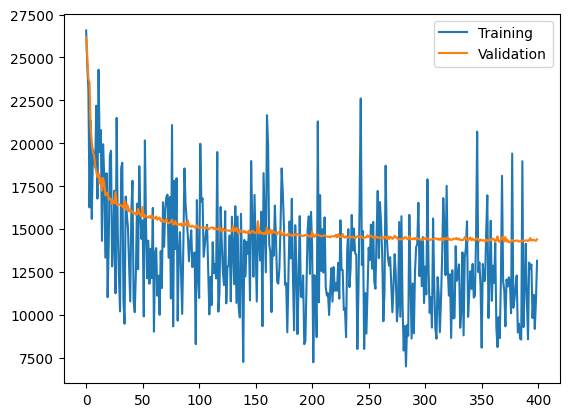

In [9]:
# Custom dataset to put into the batch loader.
class data(Dataset):
    def __init__(self):
        self.x = train_t_un
        self.y = train_t_c

    def __len__(self):
        return self.y.size(dim=0)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

train_data = data()
loader = DataLoader(train_data, batch_size=2048, shuffle=True)

model = nn.Sequential(
    nn.Linear(n_features, 512), 
    nn.ReLU(),
    nn.Linear(512, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256,128),
    nn.ReLU(),
    nn.Linear(128,1)
)
opt = torch.optim.Adam(model.parameters(), lr=.005)
n_epochs=400
train_hist, val_hist = training_batch(
    model=model,
    epochs=n_epochs,
    optimizer= opt,
    loss=nn.MSELoss(),
    loader=loader,
    t_c_val=val_t_c,
    t_u_val=val_t_un
)

plt.plot(range(n_epochs), train_hist, label="Training")
plt.plot(range(n_epochs), val_hist, label="Validation")
plt.legend()


idx = np.argmin(val_hist)

print("Training:\t", np.sqrt(train_hist[idx]))
print("Validation:\t", np.sqrt(val_hist[idx]))